# Stack Overflow Posts Analysis

# Overview and Motivation:

Stack Overflow is used by programmers all over the world to ask and answer questions about a variety of concepts in software development. What makes Stack Overflows’ platform unique though is its strict community guidelines. Users are expected to contribute quality questions and answers. However, not all users adhere to Stack Overflows’ community guidelines. What if there was a way to predict the types of questions that will generate good quality, accepted answers on Stack Overflow? Our aim is to determine the features that contribute to a Stack Overflow post generating a high score and good quality, accepted answers. Our findings will allow users on Stack Overflow to better structure their questions to increase the likelihood of receiving better quality responses and recognition on Stack Overflow. 

# Related Work:

When thinking about a topic to explore for this project, we stumbled upon a Kaggle page that referred us to the BigQuery dataset that contains almost 13 million Stack Overflow posts. We thought looking into Stack Overflow may be interesting, but we weren’t sure what questions to ask about this data set. As a result, we decided to do some research on what others have studied. When we came across a research article titled, “An Insight into the Unresolved Questions at Stack Overflow”, we thought it would be interesting to look at what features can predict the quality of a question. 

# Initial Questions:

When we started our data analysis, our initial question was the following: What features created by Stack Overflow contribute to the success of an accepted answer? However, after performing a lasso regression on all of our features, our question later evolved into the following: What features created by Stack Overflow contribute to the success of an accepted answer or question? The difference now is that we are analyzing the score of a question and accepted answer. We used features such as the # of views of a post, the score of a question or answer, and the reputation of the author of an accepted answer to answer this question. However, after using models on the existing features in our dataset, we received low scores for our regression and classification models. 
<br><br>
As a result, we wondered if we could make some features based on the text. Therefore, our second question became: What textual features in questions get better answers and more upvotes on Stack Overflow? For example, we considered the Flesch Reading Score, the punctuation and the presence of code in posts. Some of these new variables helped us to answer our original questions. Later, we questioned if there are distinct groups of posts we should investigate so we clustered the text data to find out.

# Data Gathering

Our data source for this project was Google’s BigQuery, which is described as an “enterprise data warehouse”. Firstly, we needed to understand what tables and columns were available to us. Once we decided which tables and columns we wanted to use, we wrote an SQL expression to gather a random sample of 10,000 Stack Overflow posts. 

Since our data was over 10,000 rows, we needed to export it to Google Cloud Storage (GCS) and then download it locally. 


# Data Cleaning

Upon gathering our data, we realize that we have some missing values and the textual data is in HTML format. Our first order of business is to remove any HTML tags from our code and fill in missing values with either 0 or a blank string. 

In [107]:
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from scipy import stats
from sklearn import preprocessing

def has_tag(df, cols, tag):
    df_code = pd.DataFrame() 
    for c in cols:
        code = df[c].apply(lambda text: BeautifulSoup(text, 'html.parser').find_all(tag))
        col_name = c + '_HAS_CODE' 
        code = (code.str.len() > 0).astype(int).rename(col_name).to_frame()
        df_code = pd.concat([df_code,code], axis=1)
    return df_code


def decompose_html(text, tag):   
    soup = BeautifulSoup(text, 'html.parser')
    code_tags = soup.findAll(tag)
    for code in code_tags:
        code.decompose()
    return str(soup)


def alter_col_text(df, cols, tag):   
    for c in cols:
        df[c] = df[c].apply(lambda text: decompose_html(text,tag))
        df[c] = df[c].apply(lambda text: BeautifulSoup(text, 'html.parser').text)
        df[c] = df[c].str.replace('\n',' ', regex=True)
    return df

In [108]:
import language_tool_python
import regex as re

def fill_nan_columns(df, columns):
    for column in columns:
        df[column] = df[column].fillna(0)
    return df
   
    
def outlier_treatment(df, columns,bound):
    for column in columns:
        lower = df[column].quantile(0.25)
        upper = df[column].quantile(0.75)
        IQR = upper - lower
        df.loc[df[column] < lower - bound*IQR, column] = lower
        df.loc[df[column] > upper + bound*IQR, column] = upper
    return df

In [109]:
# load data
df = pd.read_csv('data_10ktags.csv',header=0)

# clean the data. fill in nan values with either 0 or blank text. 
values = {'QUESTION_BODY': '', 'ACCEPTED_ANSWER_BODY': '', 'QUESTION_TITLE': ''}
df = df.fillna(value = values)

quant_cols = ['QUESTION_SCORE',
              'ANSWER_SCORE',
              'QUESTION_VIEWS',
              'ANSWER_COMMENT_COUNT',
              'ANSWER_REPUTATION']

df[quant_cols] = df[quant_cols].apply(pd.to_numeric, errors='coerce')
df = fill_nan_columns(df, quant_cols)

# Data Transformation

## Variable Creation

To analyze our data even further, we will create new variables to analyze the content of a Stack Overflow post. We will first begin by creating binary variables that identify whether a question body and accepted answer body, respectivly, contain code. 

In [110]:
# create binary variables for questions and answers that contain code. 
tag = 'code'
body_cols = ['QUESTION_BODY','ACCEPTED_ANSWER_BODY']
df = pd.concat([df,has_tag(df, body_cols, tag)], axis=1)

# clean the data. remove code from question and answer body
df = alter_col_text(df, body_cols, 'code')

From the tag names provided, we will create a new variable to tell us the number of tags associated with a Stack Overflow post. 

In [111]:
# create variable for number of tags with question
df['NUM_TAGS'] = df['QUESTION_TAGS'].apply(lambda text: len(text.split("|")))

We will also create variables to analyze the following features in a Stack Overflow post's question title:
<ol>
  <li>Whether the title contains a question mark at the end</li>
  <li>The Flesh Reading Ease score of the title </li>
  <li>The number of syllables in the title  </li>
</ol>


In addition, we will create variables to analyze the following features in a Stack Overflow post's question body: 
<ol>
  <li>The number of syllables in the question body</li>
  <li>The number of words in the question body</li>
</ol>

In [112]:
import textstat

# create binary variable that says if a title ends with a question mark
regex = '^[a-zA-Z0-9\s\W_\p{L}]+\?$'   
df['TITLE_HAS_PUNC'] = df['QUESTION_TITLE'].apply(lambda text: int(bool(re.search(regex, text))))

# create variable that determines the Flesh Reading Score (FRS) of a question's title
# a lower FRS score means more difficult to read

df['TITLE_FRS'] = df['QUESTION_TITLE'].apply(lambda text: textstat.flesch_reading_ease(text))

# create variable that determines the Flesh Reading Score (FRS) of a question's body
df['BODY_FRS'] = df['QUESTION_BODY'].apply(lambda text: textstat.flesch_reading_ease(text))

# create variable for # of syllables in question title
df['TITLE_SYLL_COUNT'] = df['QUESTION_TITLE'].apply(lambda text: textstat.syllable_count(text))

# create variable for # of syllables in question body
df['BODY_SYLL_COUNT'] = df['QUESTION_BODY'].apply(lambda text: textstat.syllable_count(text))

# create variable for # of words in question body
df['BODY_WORD_COUNT'] = df['QUESTION_BODY'].apply(lambda text: textstat.lexicon_count(text, removepunct=True))

After creating these new variables, we need to perform outlier treatment on our old and newly created variables. We will use a method of top and bottom coding to reduce the noise in our dataset. 

In [113]:
# outlier treatment - top and bottom coding
qa_scores = ['QUESTION_SCORE','ANSWER_SCORE']
df = outlier_treatment(df, qa_scores, 4)
other_cols = ['QUESTION_VIEWS',
              'ANSWER_COMMENT_COUNT',
              'ANSWER_REPUTATION',
              'TITLE_FRS',
              'BODY_FRS',
              'NUM_TAGS',
              'TITLE_SYLL_COUNT',
              'BODY_SYLL_COUNT',
              'BODY_WORD_COUNT']
df = outlier_treatment(df, other_cols, 1.5)

Since our data set is very uneven when it comes to the distribution of question and answer scores, we will use the RandomOverSampler from imblearn to "over-sample the minority class(es) by picking samples at random with replacement" (imbalance-learn documentation). 

In [114]:
# adjust for uneven data set. 

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

cols = df.columns.to_list()
cols.remove('ANSWER_SCORE')
y_hetero = df['ANSWER_SCORE']
X_hetero = df[cols]

X_resampled, y_resampled = ros.fit_resample(X_hetero, y_hetero)
df = pd.concat([X_resampled,y_resampled ], axis=1)


## Discretization

Here we will discretize our continuous question score and answer score data into ordinal attributes: 0: Poor, 1: Fair, 2: Good, 3: Very Good, and 4: Excellent. 

In [115]:
# binning
answer_scores = pd.cut(df['ANSWER_SCORE'],5, labels=False,duplicates='drop').__array__()
question_scores = pd.cut(df['QUESTION_SCORE'],5, labels=False,duplicates='drop').__array__()

# answer_keys = ['poor','fair','good','very good','excellent']
# question_keys = ['poor','fair','good','very good','excellent']
df['QUESTION_QUALITY'] = question_scores
df['ANSWER_QUALITY'] = answer_scores

# Data Exploration/Visualization

## Pair Plot Analysis

To start exploring the quantitative data, we first used seaborn’s pair plots to plot the different features against each other. Since the plots in the pair plot are quite scattered, we will do a bivariable analysis of the data. 

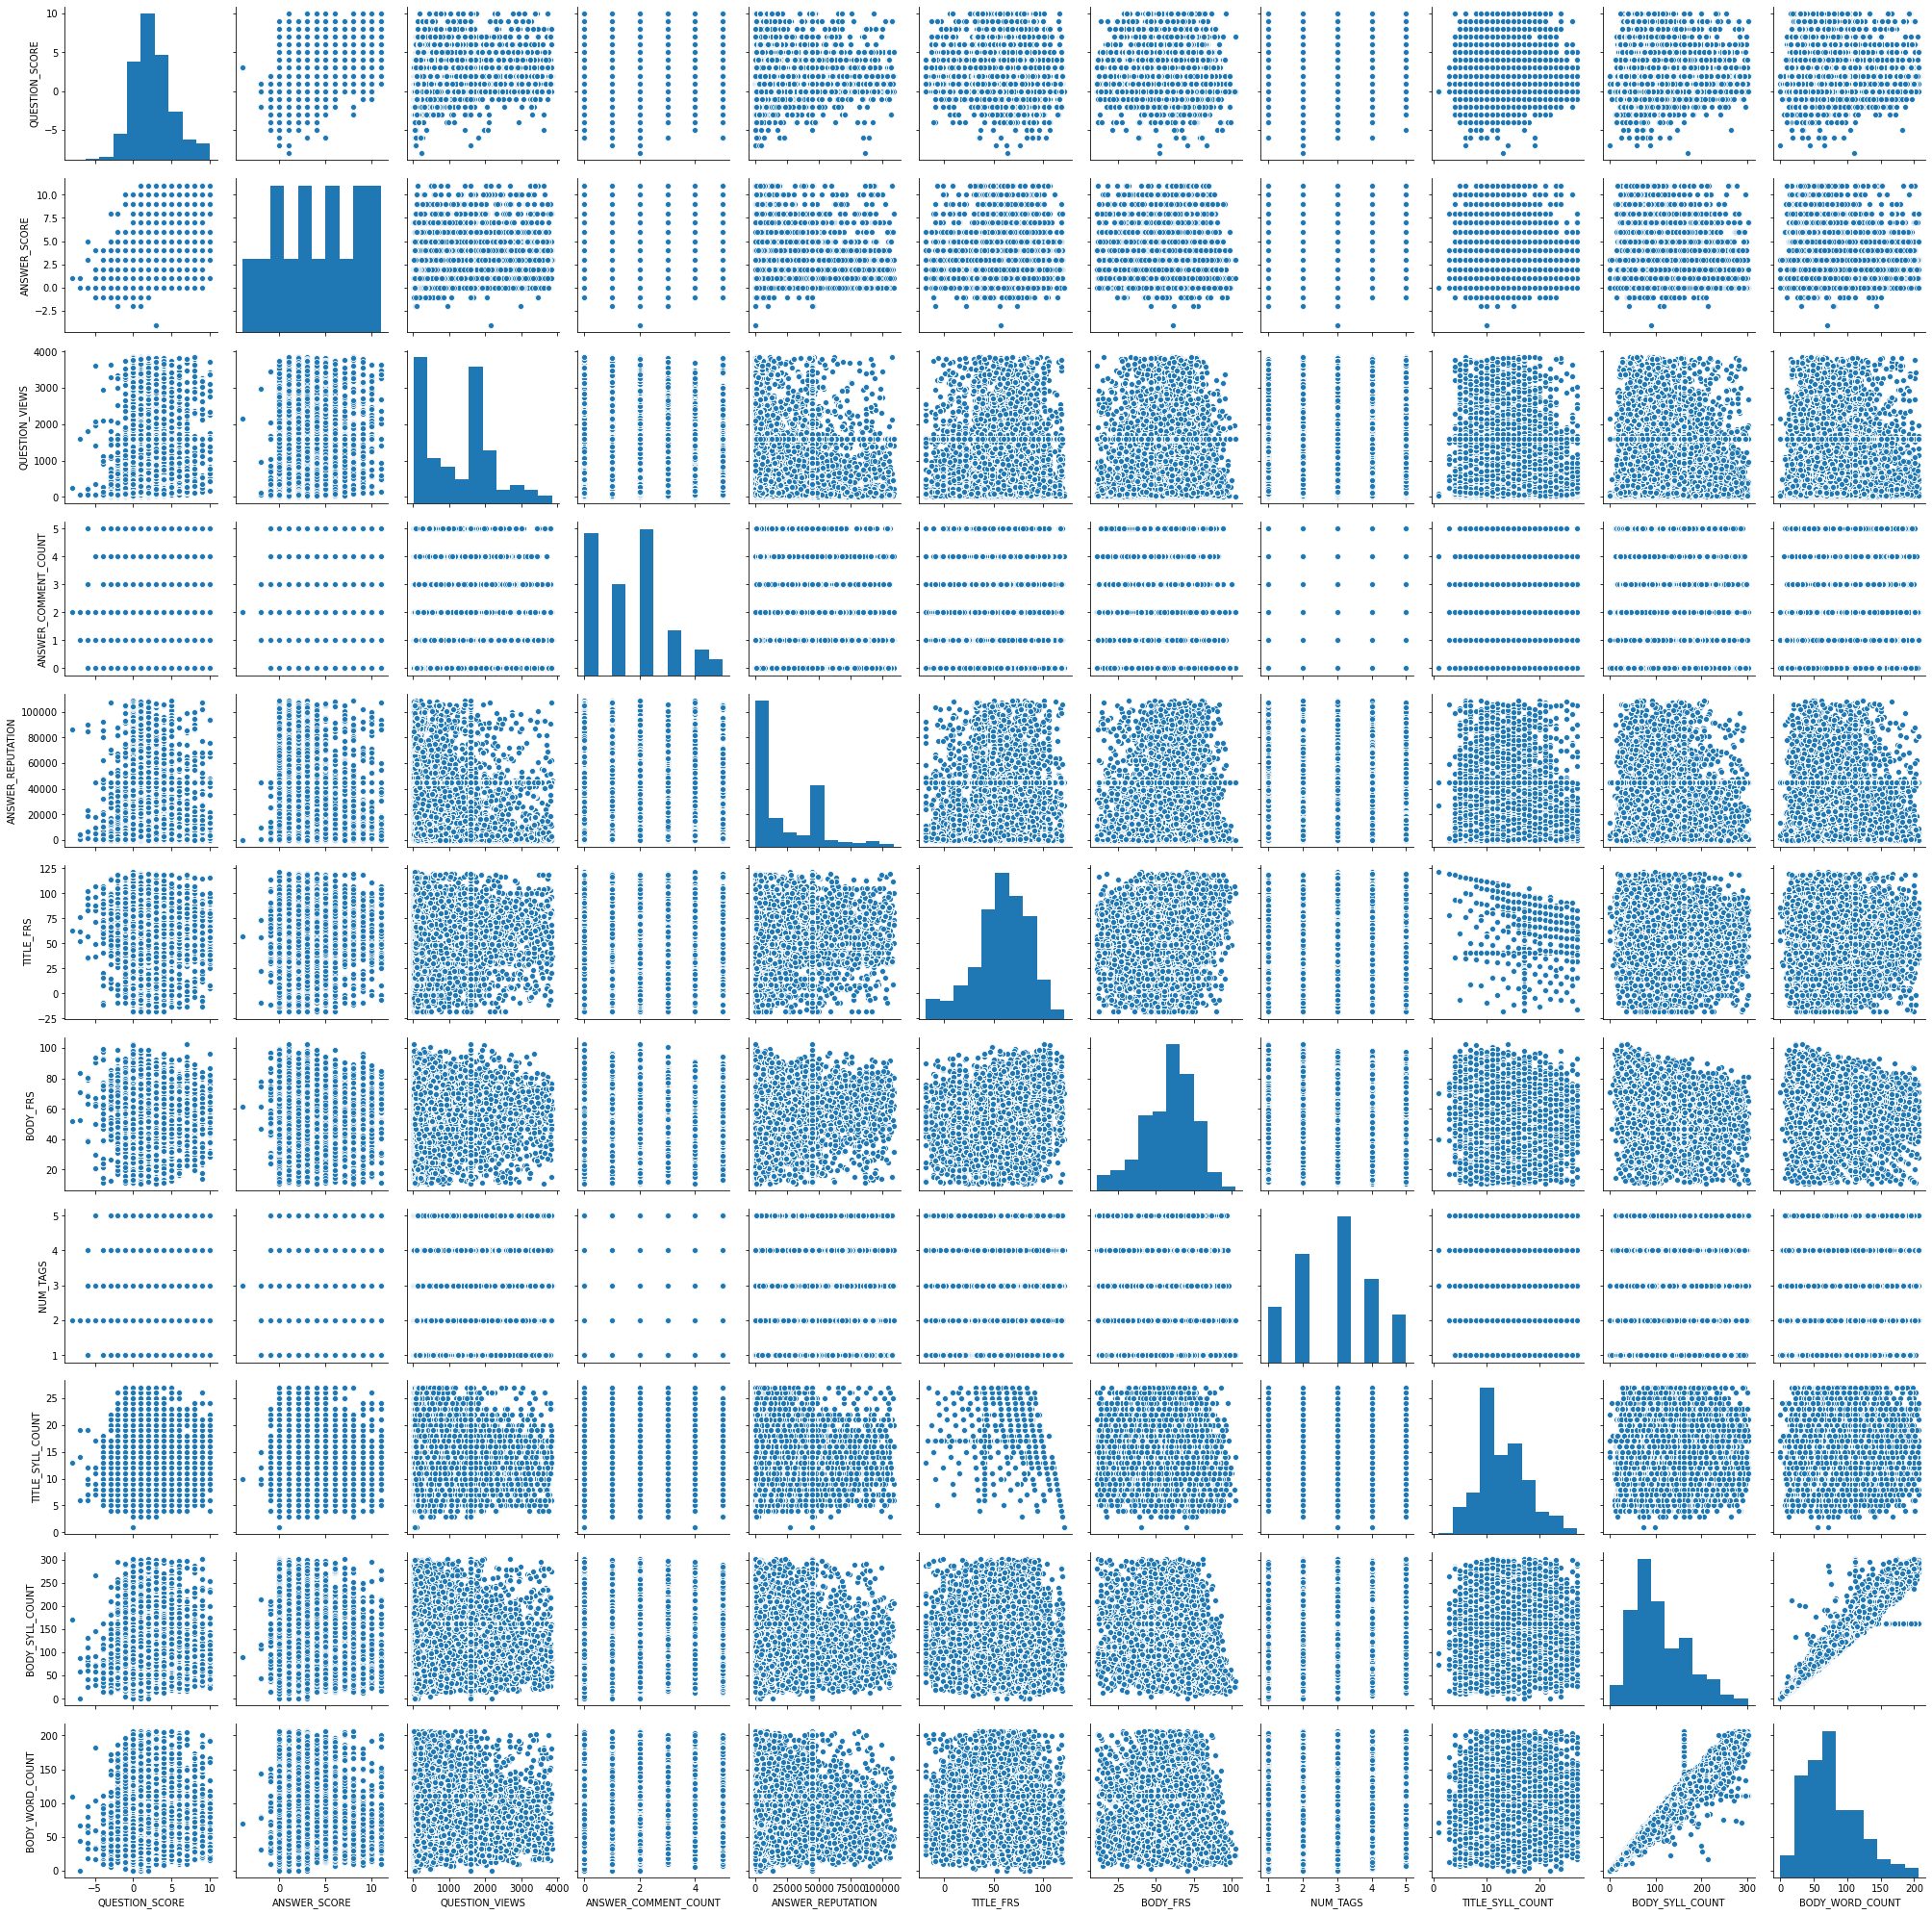

In [116]:
sns.pairplot(df[qa_scores + other_cols])

## Quantitative Bivariable Analysis 

Let's zoom in on the relationship between two different variables using bar charts. We used bar charts because they are a good visualization tool to use when plotting quantitative data against ordinal data.

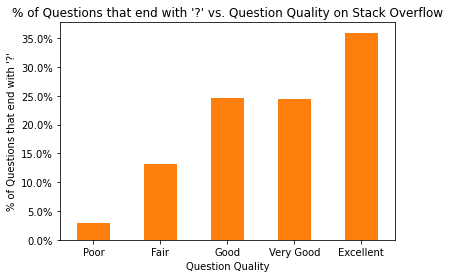

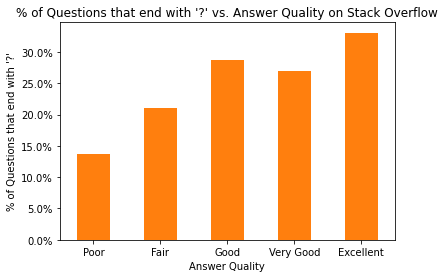

In [117]:
import matplotlib.ticker as mtick

def graph(df, title, y_data, y_label, x_label):
    ax = df.plot.bar( y=y_data, 
                      rot=0, 
                      title=title,
                      color=['C1'],
                      legend=False)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)   
    return ax


d = {0:'Poor',1:'Fair',2:'Good',3:'Very Good', 4:'Excellent'} 

# plot % of Questions with Appropriate Punctuation vs. Question Quality on Stack Overflow
q_punc_df = df[['QUESTION_QUALITY','TITLE_HAS_PUNC']].groupby(by=["QUESTION_QUALITY"]).mean()
q_punc_df['TITLE_HAS_PUNC'] = q_punc_df['TITLE_HAS_PUNC']*100
q_punc_df.index=q_punc_df.index.to_series().map(d)

ax = graph(q_punc_df, 
                    "% of Questions that end with '?' vs. Question Quality on Stack Overflow", 
                    'TITLE_HAS_PUNC',
                    "% of Questions that end with '?'", 
                    "Question Quality")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# plot % of Questions with Appropriate Punctuation vs. Answer Quality on Stack Overflow
a_punc_df = df[['ANSWER_QUALITY','TITLE_HAS_PUNC']].groupby(by=["ANSWER_QUALITY"]).mean()
a_punc_df['TITLE_HAS_PUNC'] = a_punc_df['TITLE_HAS_PUNC']*100
a_punc_df.index=a_punc_df.index.to_series().map(d)
ax = graph(a_punc_df, 
                    "% of Questions that end with '?' vs. Answer Quality on Stack Overflow", 
                    'TITLE_HAS_PUNC',
                    "% of Questions that end with '?'", 
                    "Answer Quality")

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

Based on our bar charts from our bivariable analysis, we determined that the percentage of excellent quality questions that had a question mark at the end of a question’s title was almost 3 times higher than that of poor quality questions. This shows that there is a relationship between having appropriate punctuation in a question title and the quality of a question. This makes sense since grammatically correct text is generally regarded positively. We also found that the percentage of excellent quality answers that had a question mark at the end of a question’s title was almost twice that of poor quality answers. This tells us that ending a question title with a question mark may increase the likelihood of receiving a better quality answer. This makes sense since people tend to mimic the formality and style of the person they are conversing with. 

(50.0, 85.0)

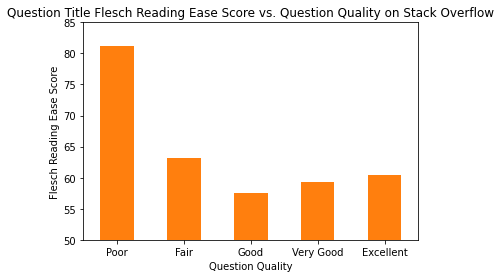

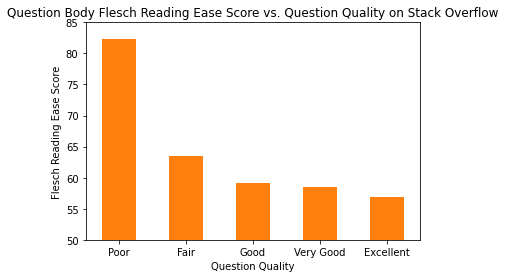

In [118]:
# plot Question Title Flesch Reading Ease Score vs. Question Quality on Stack Overflow
q_title_frs_df = df[['QUESTION_QUALITY','TITLE_FRS']].groupby(by=["QUESTION_QUALITY"]).mean()
q_title_frs_df.index=q_title_frs_df.index.to_series().map(d)
ax = graph(q_title_frs_df, 
           'Question Title Flesch Reading Ease Score vs. Question Quality on Stack Overflow', 
           'TITLE_FRS', 
           'Flesch Reading Ease Score', 
           'Question Quality')
ax.set_ylim(50,85)

# plot Question Title Flesch Reading Ease Score vs. Question Quality on Stack Overflow
q_title_frs_df = df[['QUESTION_QUALITY','BODY_FRS']].groupby(by=["QUESTION_QUALITY"]).mean()
q_title_frs_df.index=q_title_frs_df.index.to_series().map(d)
ax = graph(q_title_frs_df, 
           'Question Body Flesch Reading Ease Score vs. Question Quality on Stack Overflow', 
           'BODY_FRS', 
           'Flesch Reading Ease Score', 
           'Question Quality')
ax.set_ylim(50,85)


Another interesting finding was that the Flesch Reading Score (FRS) of a question title and question body is inversely related to the quality of a question. In other words, higher quality questions have a low FRS score (i.e. complex readability) and low-quality questions have a high FRS score (i.e. easily understandable text). This may be because higher quality questions contain more technical language. Using more technical language in a question’s title and body may incline users to upvote the post because the author of the post may be deemed as more credible and knowledgeable. We can justify this by looking at the “# of words in question body vs. question quality” and “# of syllables in question body vs. question quality” bar charts. These charts show that higher quality questions tend to have question bodies that contain more words and syllables, on average, compared to lower quality questions. FRS is calculated using the following equation: Reading Ease = 206.835 – (1.015 x Average Sentence Length) – (84.6 x Average # of Syllables/ Word). From this equation and the insights from these bar graphs, it makes sense that higher quality questions would have a lower FRS score since they tend to have longer sentences and more syllables. Also, question bodies that contain more words may be regarded as more descriptive which increases their quality. However, there was no relationship between the accepted answer quality and FRS score. 

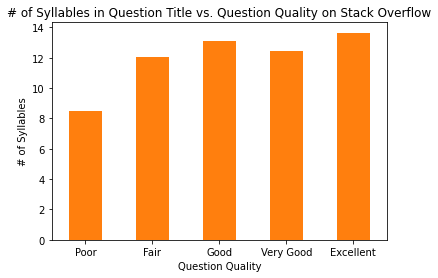

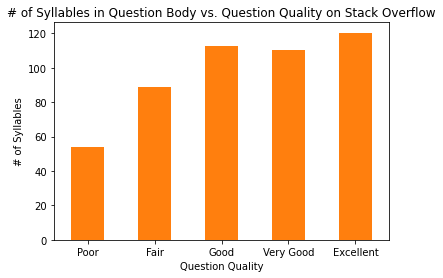

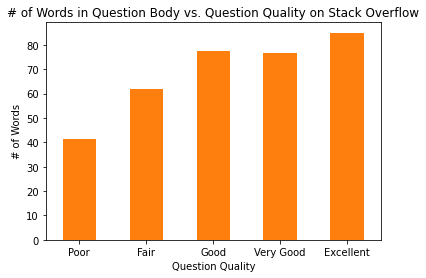

In [119]:
# plot # of Syllables in Question Title vs. Question Quality on Stack Overflow
len_df = df[['QUESTION_QUALITY','TITLE_SYLL_COUNT']].groupby(by=["QUESTION_QUALITY"]).mean()
len_df.index=len_df.index.to_series().map(d)
ax = graph(len_df, 
           "# of Syllables in Question Title vs. Question Quality on Stack Overflow", 
           'TITLE_SYLL_COUNT', 
           "# of Syllables",
           'Question Quality')

# plot # of Syllables in Question Body vs. Question Quality on Stack Overflow
len_df = df[['QUESTION_QUALITY','BODY_SYLL_COUNT']].groupby(by=["QUESTION_QUALITY"]).mean()
len_df.index=len_df.index.to_series().map(d)
ax = graph(len_df, 
           "# of Syllables in Question Body vs. Question Quality on Stack Overflow", 
           'BODY_SYLL_COUNT', 
           "# of Syllables",
           'Question Quality')

# plot # of Words in Question Body vs. Question Quality on Stack Overflow
len_df = df[['QUESTION_QUALITY','BODY_WORD_COUNT']].groupby(by=["QUESTION_QUALITY"]).mean()
len_df.index=len_df.index.to_series().map(d)
ax = graph(len_df, 
           "# of Words in Question Body vs. Question Quality on Stack Overflow", 
           'BODY_WORD_COUNT', 
           "# of Words",
           'Question Quality')

(2.0, 3.2)

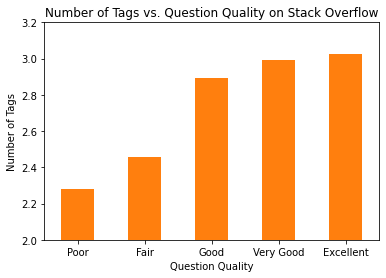

In [120]:
# plot Number of Tags vs. Question Quality on Stack Overflow
num_tags_df = df[['QUESTION_QUALITY','NUM_TAGS']].groupby(by=["QUESTION_QUALITY"]).mean()
num_tags_df.index=num_tags_df.index.to_series().map(d)
ax = graph(num_tags_df, 
           'Number of Tags vs. Question Quality on Stack Overflow', 
           'NUM_TAGS', 
           'Number of Tags', 
           'Question Quality')
ax.set_ylim(2,3.2)

In addition, as suspected, higher quality questions tend to have more tags, on average, compared to lower quality questions. This makes sense since adding more tags increases the visibility of a question. 

## Text Visualization

Next, let's analyze what the most frequently used words are in Excellent and Poor quality Stack Overflow posts using word clouds. 

In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer
import operator
import matplotlib.pyplot as plt 
from wordcloud import WordCloud

def print_word_cloud(quality):
    corpus = None
    if quality == 'Excellent':
        corpus = df[df['QUESTION_QUALITY']  == 4] ['QUESTION_BODY'].values.tolist()
    else:
        corpus = df[df['QUESTION_QUALITY']  == 0] ['QUESTION_BODY'].values.tolist()


    vectorizer = TfidfVectorizer(min_df=0.08, 
                                 stop_words='english')
    vectorizer.fit_transform(corpus)
    tfidf_freq = vectorizer.idf_
    features = vectorizer.get_feature_names()
    tfidf_freq = dict(zip(features,tfidf_freq))
    
    wc = WordCloud(background_color="black")
    wc.generate_from_frequencies(tfidf_freq)

    plt.figure(figsize=(15,10), facecolor='k')
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

What are the most frequently used words in *excellent* quality Stack Overflow questions? The most found word across excellent quality questions was the word “change”. Questions that contain the word “change” may be positively regarded since the asker seems to have made a genuine attempt to solve their problem by attempting different alternatives.  

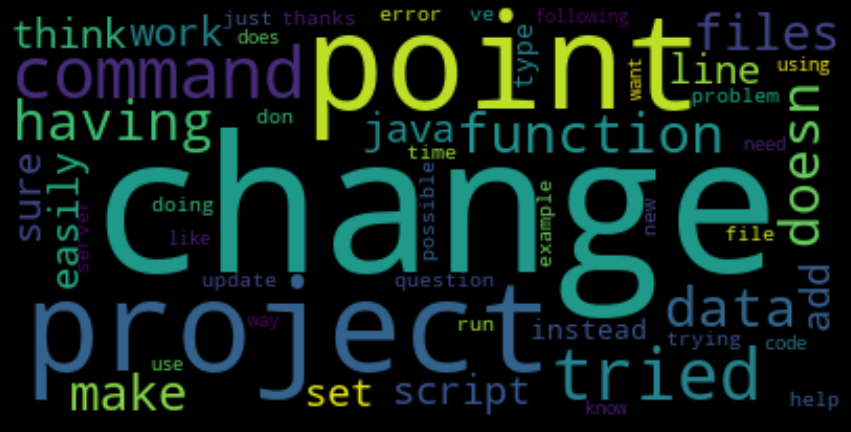

In [122]:
print_word_cloud('Excellent')

What are the most frequently used words in *poor* quality Stack Overflow questions? It was quite interesting to us that the most found word across poor quality questions is the word “error”. This tells us that a question may be considered poor if an asker is only concerned with an error in their code. 

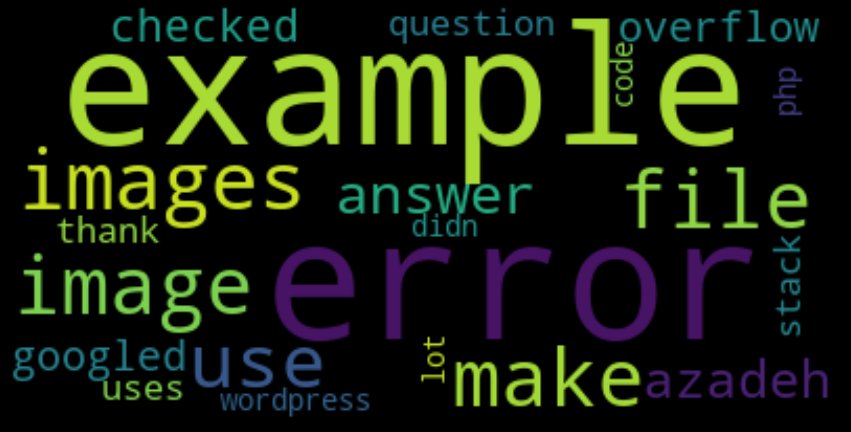

In [123]:
print_word_cloud('Poor')

## Lasso Regression

We will now use lasso regression to analyze any significant correlations between certain features. Since we want to avoid overfitting, we will use a 10-fold cross-fold validation. In addition, to normalize the columns against each other, we will use the StandardScaler function from sklearn. Lastly, we will plot the coefficient values using horizontal bar charts to find significant features that were produced from Lasso Regression. 

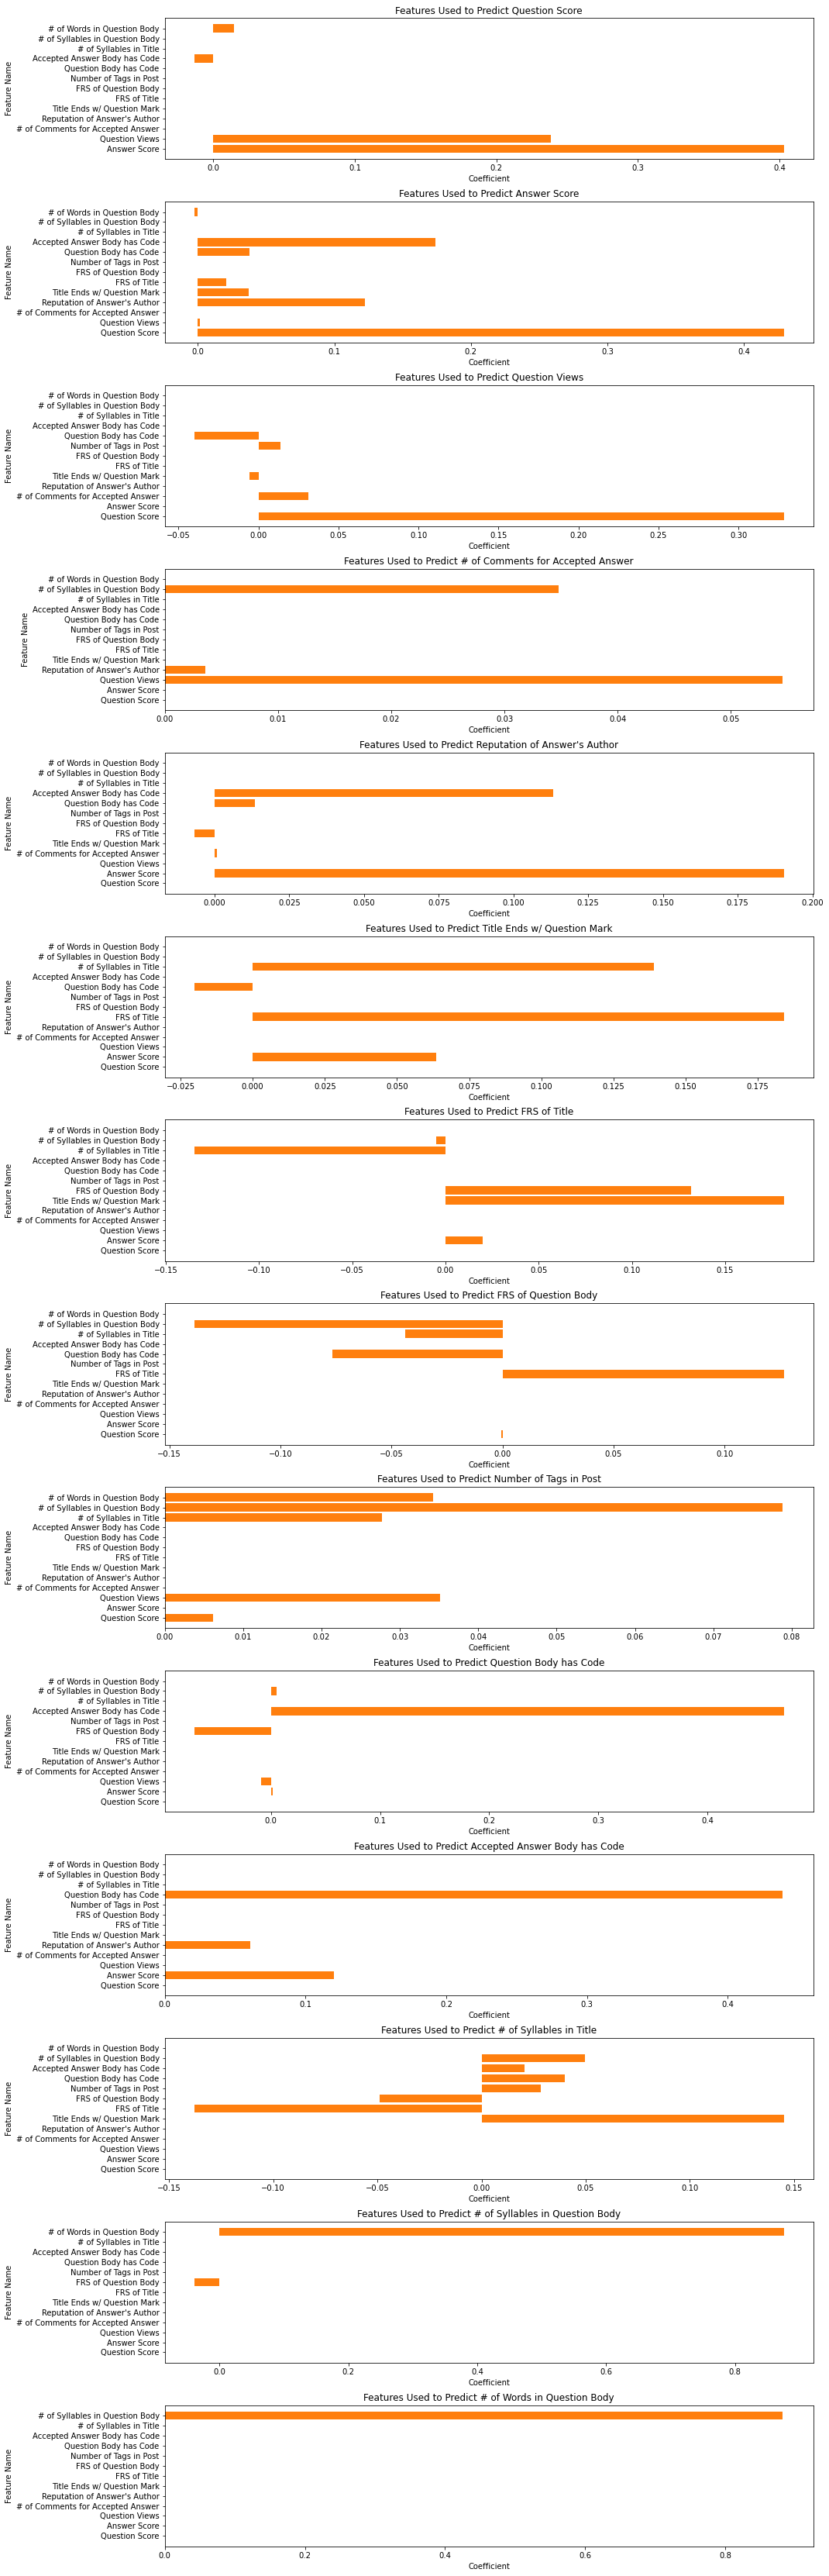

In [124]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Predict each of the following features using every other feature as its predictors
all_predictors = ['QUESTION_SCORE',
                 'ANSWER_SCORE',
                 'QUESTION_VIEWS',
                 'ANSWER_COMMENT_COUNT',
                 'ANSWER_REPUTATION',
                 'TITLE_HAS_PUNC',
                 'TITLE_FRS',
                 'BODY_FRS',
                 'NUM_TAGS',
                 'QUESTION_BODY_HAS_CODE',
                 'ACCEPTED_ANSWER_BODY_HAS_CODE',
                 'TITLE_SYLL_COUNT',
                 'BODY_SYLL_COUNT',
                 'BODY_WORD_COUNT']

# Regression on quantitative data
kf = KFold(n_splits=10, random_state=0, shuffle=True)
lasso = Lasso(alpha=0.07)
df_scaled = df.copy()
fig, axs = plt.subplots(14,figsize=(15,60))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
j = 0

for column in all_predictors:
    train_score_sum = 0
    test_score_sum = 0
    coeff_sums = {}
    count = 0
    feature = column
    predictors = [x for x in all_predictors if x != column]
    for predictor in predictors:
        coeff_sums[predictor] = 0.0
    
    ss = StandardScaler()

    df_scaled[all_predictors] = ss.fit_transform(df_scaled[all_predictors])
    for train_index, test_index in kf.split(df_scaled):
        X_train = df_scaled[predictors].iloc[train_index]
        y_train = df_scaled[feature].iloc[train_index]
        X_test = df_scaled[predictors].iloc[test_index]
        y_test = df_scaled[feature].iloc[test_index]
    
        lasso.fit(X_train, y_train)

        train_score_sum += lasso.score(X_train, y_train)
        test_score_sum += lasso.score(X_test, y_test)
        count += 1
        
        i = 0
        for predictor in predictors:
            coeff_sums[predictor] += lasso.coef_[i]
            i += 1
    
    proper_predictor_names = ['Question Score',
                             'Answer Score',
                             'Question Views',
                             '# of Comments for Accepted Answer',
                             'Reputation of Answer\'s Author',
                             'Title Ends w/ Question Mark',
                             'FRS of Title',
                             'FRS of Question Body',
                             'Number of Tags in Post',
                             'Question Body has Code',
                             'Accepted Answer Body has Code',
                             '# of Syllables in Title',
                             '# of Syllables in Question Body',
                             '# of Words in Question Body']
    
    proper_feature_name = proper_predictor_names[all_predictors.index(feature)]
    proper_predictor_names.remove(proper_feature_name)
    features = []
    coefs = []

    for predictor in predictors:  
        coefs.append(coeff_sums[predictor]/count)
        idx = predictors.index(predictor)
        features.append(proper_predictor_names[idx])
    axs[j].barh(features, coefs,color=['C1'])
    axs[j].set_xlabel('Coefficient')
    axs[j].set_ylabel('Feature Name')
    axs[j].set_title('Features Used to Predict ' + proper_feature_name)
    j+=1
 

From our initial lasso regression, we learned that the data is incredibly sparse and couldn’t generate that many “good” correlations. Therefore, we decided to gather more variables and create new variables. Despite gathering more variables, our coefficients were still quite low. However, we realized that certain features have some correlation with answer scores and question scores. Namely, the question score, the presence of code in the question, the presence of code in the answer, and the accepted answer’s author’s reputation are good predictors of answer quality. In addition, question views, answer score, and # of words in the question body are good predictors of question quality. 

## Text Classification


In order to predict the question quality or answer quality of a Stack Overflow post based on the question body, question title, or accepted answer body, we used a random forest classifier. 
<br><br>
We used a tfidf vector that did not use idf since the text data is very sparse. In addition, we set the max features to 2685 to use the top 1% of features (the total number of features was found to be 26850). Since we also wanted to consider the punctuation within the text body when predicting, we came up with a regular expression for the token pattern. In addition, to avoid overfitting for our random forest classifier, we used a 10-fold cross-fold validation, limited the depth of our trees to 16, and set our max features to the square root of the total number of features in our tf idf vector. To increase the accuracy of our classifier, we decided to use 20 tree estimators, especially since we are using text data. In the end, we generated a 71% test accuracy score which is a fairly acceptable score for us. To visualize our classifier, we used a GUI so that users could better interact with our classifier and determine the quality of their Stack Overflow question or accepted answer based on their question body, title, or accepted answer body. 
<br><br>
Without tuning our Random Forest Classifier, the classifier outputted an accuracy score of around 97% which told us that the classifier was significantly overfitting the data since the model was considering almost 30,000 features. As a result, we tuned the classifier and decreased the accuracy score to a more reasonable value of 70%. If the accuracy score was 20%, then we would conclude that the classifier was randomly classifying the text data. However, the accuracy score tells us that although around ¼ of the predictions will be incorrect, the classifier is not just randomly predicting values. 

In [177]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from itertools import combinations 
from sklearn.model_selection import KFold

def text_classifier(X_list,y_list, prediction_string):
    qualities = {0: 'Poor', 1: 'Fair', 2: 'Good', 3: 'Very Good', 4: 'Excellent'}
    kf = KFold(n_splits=5, random_state=0, shuffle=True)
    count = 0
    train_score_sum = 0
    test_score_sum = 0
    prediction = 0

    for X, Y in zip(X_list, y_list):
        for train_index, test_index in kf.split(df):  
            # split X into train and test data
            X_train = df[X].iloc[train_index]
            y_train = df[Y].iloc[train_index]
            X_test = df[X].iloc[test_index]
            y_test = df[Y].iloc[test_index]

            # vectorize train data
            vectorizer = TfidfVectorizer(use_idf=False, 
                                         max_features=2685, 
                                         token_pattern=r"(?u)\b\w\w+\b|!|\?|\"|\'")
            X_train = vectorizer.fit_transform(X_train.values.astype('U')).toarray()
            # RF classifier building
            clf = RandomForestClassifier(n_estimators=20, random_state=0, max_depth=16)
            clf.fit(X_train, y_train)

            # Test RF classifier with score on train and test data
            X_test = vectorizer.transform(X_test.values.astype('U')).toarray()

            train_score_sum += clf.score(X_train, y_train)
            test_score_sum += clf.score(X_test, y_test)
            prediction += clf.predict(vectorizer.transform([prediction_string]).toarray())
            count += 1

    return qualities[int(prediction/count)]

Test out our prediction GUI by running the cell below! It takes around 1 to 2 minutes to run ...

In [178]:
# *sources: https://www.youtube.com/watch?v=YXPyB4XeYLA
from tkinter import *

root = Tk()
input_string = Text(root, width=40, height = 20)

# run classifier corresponding to the chosen option menu
def predict():
    X = None
    if clicked.get() == 'Question Title':
        X = "QUESTION_TITLE"
    elif clicked.get() == 'Question Body':
        X = "QUESTION_BODY"
    elif clicked.get() == 'Accepted Answer Body':
        X = "ACCEPTED_ANSWER_BODY"
    
    if clicked_2.get() == 'Question Quality':
        Y = 'QUESTION_QUALITY'
    else:
        Y = 'ANSWER_QUALITY'
    prediction_string = [input_string.get("1.0", "end")][0]
    prediction['text'] = text_classifier([X],[Y], prediction_string)

clicked = StringVar()
clicked.set('Question Title')
drop = OptionMenu(root, clicked, 'Question Title', 'Question Body', 'Accepted Answer Body')

clicked_2 = StringVar()
clicked_2.set('Question Quality')
drop_2 = OptionMenu(root, clicked_2, 'Question Quality', 'Answer Quality')

label1 = Label(root, text='Random Forest Classifier Prediction')
label2 = Label(root, text='Choose a text body to classify and input your test input.')
label3 = Label(root, text='Would you like to predict question or answer quality?')
prediction = Label(root, text='Prediction: ')
button = Button(root, text='Predict', command=predict)

label1.grid(row=0, column=0)
label2.grid(row=2, column=0)
drop.grid(row=4, column=0)
label3.grid(row=6, column=0)
drop_2.grid(row=8, column=0)
button.grid(row=10,column=0)
input_string.grid(row=12,column=0)
prediction.grid(row=14,column=0)

root.mainloop()

## Quantitative Feature Classification
We will now attempt to classify a post's accepted answer quality by its quantitative features. The quantitative features we will use to classify a post's *accepted answer quality* are the score of a question, the presence of code in the question, the presence of code in the accepted answer, and the accepted answer’s author’s reputation. 
We will use these features because our Lasso Regression analysis showed that these features had a considerable impact on a post's accepted answer score. To avoid overfitting, we will use 10-fold cross-fold validation and limit the depth of our decision tree to 13. We chose a depth of 13 since this generates a test accuracy score of 71% which is a fairly acceptable score for us. 
<br> <br>
Our decision tree classification shows us that it is easier to predict the success of an answer using these numerical features rather than the text itself. However, both classifiers are significantly better than randomly guessing since their accuracy scores are around 70% rather than 20%. Both of these models were evaluated by scikit-learn’s respective score functions.

In [179]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def quantitative_classifier(question_score, body_has_code, acc_ans_has_code, ans_rep):
    qualities = {0: 'Poor', 1: 'Fair', 2: 'Good', 3: 'Very Good', 4: 'Excellent'}
    X = ['QUESTION_SCORE',
         'QUESTION_BODY_HAS_CODE',
         'ACCEPTED_ANSWER_BODY_HAS_CODE',
         'ANSWER_REPUTATION']
    y = ['ANSWER_QUALITY']

    kf = KFold(n_splits=10, random_state=0, shuffle=True)
    count = 0
    train_score_sum = 0
    test_score_sum = 0
    prediction_sum = 0

    for train_index, test_index in kf.split(df):  

        X_train = df[X].iloc[train_index]
        y_train = df[y].iloc[train_index]
        X_test = df[X].iloc[test_index]
        y_test = df[y].iloc[test_index]

        clf = tree.DecisionTreeClassifier(max_depth=13)
        clf.fit(X_train, y_train.values.ravel())
        
        clf_pred = clf.predict(X_test)
        
        train_score_sum += clf.score(X_train, y_train)
        test_score_sum += clf.score(X_test, y_test)

        prediction_sum += clf.predict([[question_score, body_has_code, acc_ans_has_code, ans_rep]])
        count += 1

    #print('Score on train data:', train_score_sum*100/count, '%')
    #print('Score on test data:', test_score_sum*100/count,'%')
    #print('PREDICTION:', int(prediction_sum/count))
    print('F1 Score           :', f1_score(y_test, clf_pred,average='macro'))
    fig = plt.figure(figsize=(5, 5)) 
    mat = confusion_matrix(y_test, clf_pred) 
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar = False, cmap=plt.cm.Blues)
    plt.title('Quantitative Feature Classification Confusion matrix')
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.show()
    return qualities[int(prediction_sum/count)]

Test out our prediction GUI by running the cell below! It runs fast!

F1 Score           : 0.7177843840636963


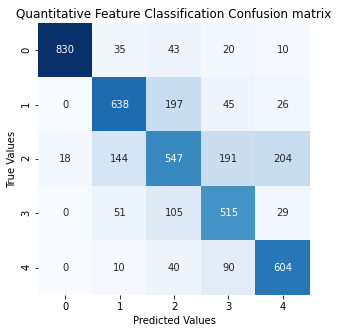

In [ ]:
from functools import partial
window = Tk()

input_string = Text(window, width=40, height = 20)

def map_binary(widget):
    if widget.get() == 'Yes':
        return 1
    else:
        return 0

def predict_Quantitative(label_result, n1,n2,n3,n4):
    QUESTION_SCORE = int(n1.get())

    QUESTION_BODY_HAS_CODE = int(n2.get())
    ACCEPTED_ANSWER_BODY_HAS_CODE = map_binary(n3)
    ANSWER_REPUTATION = map_binary(n4)
    prediction = quantitative_classifier(QUESTION_SCORE,
                                         QUESTION_BODY_HAS_CODE,
                                         ACCEPTED_ANSWER_BODY_HAS_CODE,
                                         ANSWER_REPUTATION)
    label_result.config(text="Result: " + prediction) 
    return

window.title("Quantitative Feature Classifier")

number1 = StringVar()  
number2 = StringVar()  

labelResult = Label(window)  

labelResult.grid(row=7, column=1)

lbl = Label(window, text = "Please Enter three values below")
clicked = StringVar()
clicked.set('Yes')
Label(window, text="Does the Question Body have Code?").grid(row=1)
drop = OptionMenu(window, clicked, 'Yes', 'No').grid(row=1, column=1)
clicked_1 = StringVar()
clicked_1.set('Yes')
Label(window, text="Does the Accepted Answer Body have Code?").grid(row=2)
drop_1 = OptionMenu(window, clicked_1, 'Yes', 'No').grid(row=2, column =1)

Label(window, text="Question Score").grid(row=3)
e2 = Entry(window, textvariable=number1).grid(row=3, column =1)

Label(window, text="Reputation of Author of Accepted Answer").grid(row=4)
e3 = Entry(window, textvariable=number2).grid(row=4, column =1)

lbl.grid(row = 1, column = 0)

call_result = partial(predict_Quantitative, labelResult, number1, number2, clicked, clicked_1)

button = Button(window, text='Predict', command=call_result).grid(row=6,column=1)

window.mainloop()

We also printed a confusion matrix to check how many predicted values match with the real values, and then we checked our approximation by printing the F-1 score. For example, from this matrix we can see that our model predicted 90 posts as having a quality of “Very Good” when they were supposed to be “Excellent”.

### Clustering

Another question which interested us was whether there were distinct groups of text which could be viewed in clustering. To answer this, we implemented agglomerative clustering on the question title. We found that the results were best for the title rather than the body of the question or answer. PCA is used to reduce the dimensionality and view the clusters. To get an idea of each cluster, we found the most common words from each cluster.

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ninakaake/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


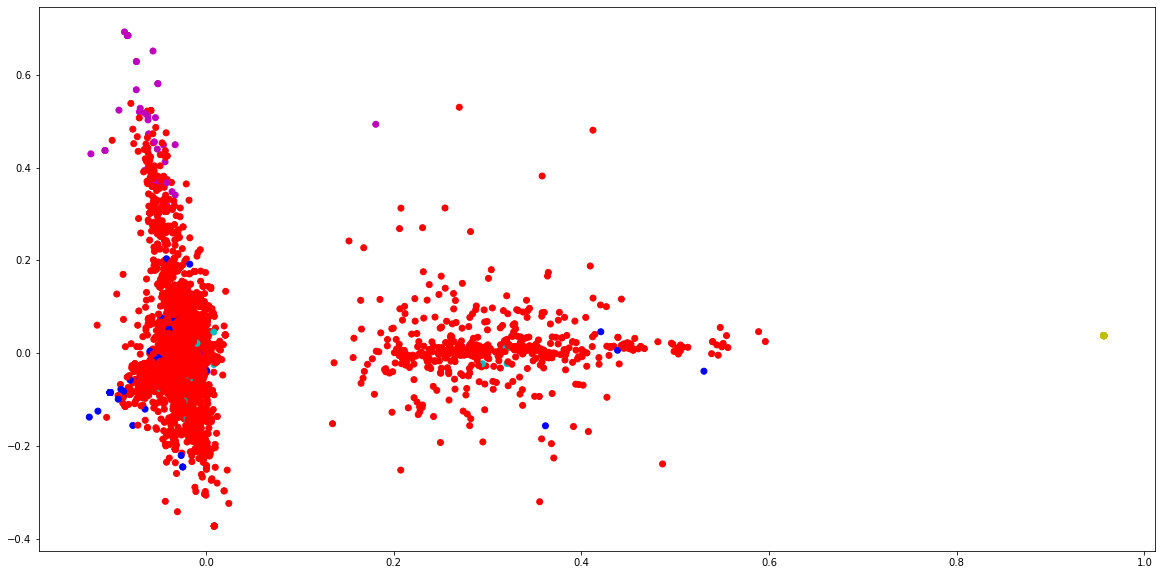

In [181]:
# sources: 
# https://stackoverflow.com/questions/4371231/removing-punctuation-from-python-list-items
# https://www.geeksforgeeks.org/find-k-frequent-words-data-set-python/

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import Counter 
import string
import nltk
nltk.download('stopwords')

vectorizer = TfidfVectorizer(stop_words='english', max_features=500)

temp = df['QUESTION_TITLE'][:7000]
X = vectorizer.fit_transform(temp)

agglomerative_clusters = AgglomerativeClustering(n_clusters=5).fit_predict(X.toarray())

# change clusters to 2 dimensions for plotting
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(X.toarray())

colors = ["r", "b", "c", "y", "m" ]

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]
fig, ax = plt.subplots(figsize=(20,10))

# plot the clusters
ax.scatter(x_axis, y_axis, c=[colors[d] for d in agglomerative_clusters])

cluster_0 = []
cluster_1 = []
cluster_2 = []
cluster_3 = []
cluster_4 = []
    
stopwords = nltk.corpus.stopwords.words('english')

# Group together titles from the same clusters
for i, txt in enumerate(temp):
    # clean up words title
    word_list = str(txt).split()
    word_list = [word.lower() for word in word_list]
    word_list = [''.join(letter for letter in word if letter not in string.punctuation) for word in word_list]
    word_list = [word for word in word_list if word]
    word_list_no_stop = [word for word in word_list if word not in stopwords]
    # add title to proper cluster
    if agglomerative_clusters[i] == 0:
        cluster_0.extend(word_list_no_stop)
    elif agglomerative_clusters[i] == 1:
        cluster_1.extend(word_list_no_stop)
    elif agglomerative_clusters[i] == 2:
        cluster_2.extend(word_list_no_stop)
    elif agglomerative_clusters[i] == 3:
        cluster_3.extend(word_list_no_stop)
    else:
        cluster_4.extend(word_list_no_stop)
            
counter_0 = Counter(cluster_0)
counter_1 = Counter(cluster_1) 
counter_2 = Counter(cluster_2) 
counter_3 = Counter(cluster_3) 
counter_4 = Counter(cluster_4) 
    
most_occur_0 = counter_0.most_common(10) 
most_occur_1 = counter_1.most_common(10)
most_occur_2 = counter_2.most_common(10)
most_occur_3 = counter_3.most_common(10)
most_occur_4 = counter_4.most_common(10)

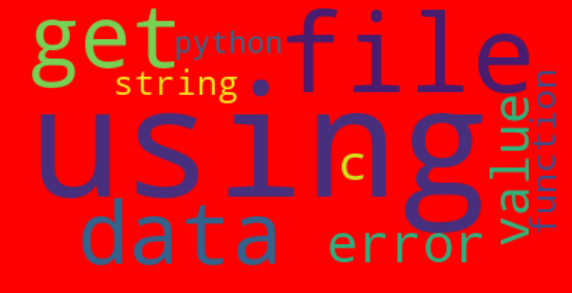

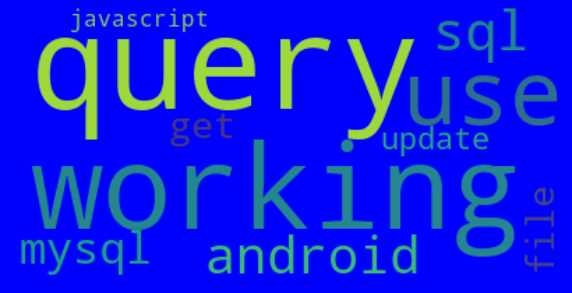

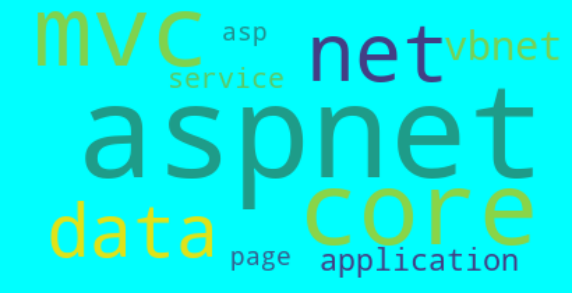

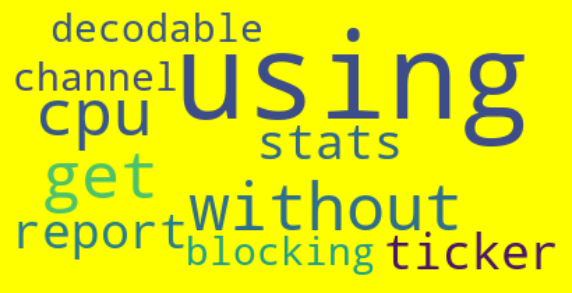

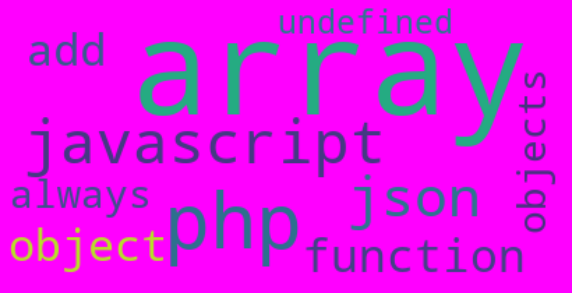

In [182]:
colors = ['red', 'blue', 'cyan', 'yellow', 'magenta']
clusters = [most_occur_0, most_occur_1, most_occur_2, most_occur_3, most_occur_4]
clusters = [dict(x) for x in clusters]

for color,cluster in zip(colors, clusters):  
    wc = WordCloud(background_color=color)
    wc.generate_from_frequencies(cluster)

    plt.figure(figsize=(10,10), facecolor=color)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


The clusters we obtained from agglomerative clustering were  not clearly defined.However, The clusters held roughly different locations in the two dimensional graph obtained by PCA. By viewing the top ten words from each of the clusters, we attempted to understand if the clustered titles contained distinct themes. We observed the following:
<ol>
    <li>The first (red) cluster is related to obtaining data from a file. </li>
    <li>The second (blue) uses words common when working with databases. </li>
    <li>The third (teal) has a strong relation to web development.</li>
    <li>The fourth (yellow) cluster uses words related in outputs and statistics, but also contains some unrelated noise.</li>
    <li>The fifth (magenta) cluster mentions javascript and terms related to it.</li>
</ol>

In [ ]:
# SOURCES:
# https://stackoverflow.com/questions/53189494/apply-beautifulsoup-function-to-pandas-dataframe
# https://stackoverflow.com/questions/20297317/python-dataframe-pandas-drop-column-using-int
# Data Cleaning Notebook from Week 2 
# https://stackoverflow.com/questions/17383094/how-can-i-map-true-false-to-1-0-in-a-pandas-dataframe
# https://stackoverflow.com/questions/39885359/beautifulsoup-decompose
# https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame
# https://stackoverflow.com/questions/8080890/initialize-dict-with-keys-values-from-two-list
# https://stackoverflow.com/questions/9012008/pythons-re-return-true-if-string-contains-regex-pattern
# https://stackoverflow.com/questions/31357611/format-y-axis-as-percent
# https://stackoverflow.com/questions/49057154/how-to-use-map-in-index-of-pandas-dataframe
# https://www.kirenz.de/post/2019-08-12-python-lasso-regression-auto/python-lasso-regression/
# https://amueller.github.io/word_cloud/auto_examples/frequency.html?highlight=freq
# https://www.w3resource.com/python-exercises/dictionary/python-data-type-dictionary-exercise-1.php
# https://stackoverflow.com/questions/39803254/modifying-many-columns-in-pandas-dataframe
# https://scikit-learn.org/stable/modules/tree.html
# https://graphviz.readthedocs.io/en/stable/manual.html#styling
# https://stackoverflow.com/questions/39254134/how-to-preserve-punctuation-marks-in-scikit-learn-text-countvectorizer-or-tfidfv
# https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.html
# https://stackoverflow.com/questions/48431173/is-there-a-way-to-get-only-the-idf-values-of-words-using-scikit-or-any-other-pyt
# https://stackoverflow.com/questions/6522446/list-of-tuples-to-dictionary
# https://stackoverflow.com/questions/57626286/how-to-plot-text-clusters
# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/19252430